# __0. LIBRARIES & MISC__

In [ ]:
# CORE
import numpy as np
import pandas as pd

# VISUALISATIONS
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# PROCESSING & PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# CLUSTERING
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster.hierarchy import cut_tree
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score, silhouette_samples

# WARNINGS
import warnings

## 0.1. Functions

In [ ]:
# SILHOUETTE SCORE PLOTTING
# K-means
def plot_silhouette(ax, silhouette_vals, labels, title, n_clusters, data):
    # Initial y location
    y_lower = 0
    legend_patches = []  # Store handles for legend
    for i in range(n_clusters):
        # SScores for the current cluster and sort them for better visualization
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        # Size of the cluster
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        # Plot the cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, label=f"{size_cluster}")
        # Make sure the next cluster start above current one
        y_lower = y_upper
    
    # Plot the Silhouette score line
    ax.axvline(x=silhouette_score(data, labels), color="red", linestyle="--")

    # Plot labels
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Members")
    ax.set_title(title)
    ax.set_ylim(0, 50)
    ax.legend(title='Cluster Size', loc='lower right')


# Hierarchical
def plot_silhouette_hclust(ax, silhouette_vals, labels, title, n_clusters, data):
    # Initial y location
    y_lower = 0
    legend_patches = []  # Store handles for legend
    for i in range(1, n_clusters+1):
        # SScores for the current cluster and sort them for better visualization
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        # Size of the cluster
        size_cluster = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster
        # Plot the cluster
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7, label=f"{size_cluster}")
        # Make sure the next cluster start above current one
        y_lower = y_upper
    
    # Plot the Silhouette score line
    ax.axvline(x=silhouette_score(data, labels), color="red", linestyle="--")

    # Plot labels
    ax.set_xlabel("Silhouette Coefficient Values")
    ax.set_ylabel("Cluster Members")
    ax.set_title(title)
    ax.set_ylim(0, 50)
    ax.legend(title='Cluster Size', loc='lower right')

## 0.2. MISC

In [ ]:
# Remove warnings
warnings.filterwarnings("ignore")
# Set random seed
rng = 42

# __1. DATA__

## 1.1. Data Processing

In [124]:
# Load the dataset and preview the dataset
df = pd.read_csv("IMDB-Movies.csv")
df.head()

,Unnamed: 0,Title,Genre,Description,Director,Actors,Year,Runtime..Minutes.,Rating,Votes,Revenue..Millions.
0,1,The Dark Knight,"Action,Crime,Drama",When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart,Mi...",2008,152,9.0,1791916,533.32
1,2,Inception,"Action,Adventure,Sci-Fi","A thief, who steals corporate secrets through ...",Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",2010,148,8.8,1583625,292.57
2,3,Dangal,"Action,Biography,Drama",Former wrestler Mahavir Singh Phogat and his t...,Nitesh Tiwari,"Aamir Khan, Sakshi Tanwar, Fatima Sana Shaikh,...",2016,161,8.8,48969,11.15
3,4,Interstellar,"Adventure,Drama,Sci-Fi",A team of explorers travel through a wormhole ...,Christopher Nolan,"Matthew McConaughey, Anne Hathaway, Jessica Ch...",2014,169,8.6,1047747,187.99
4,5,Kimi no na wa,"Animation,Drama,Fantasy",Two strangers find themselves linked in a biza...,Makoto Shinkai,"Ryûnosuke Kamiki, Mone Kamishiraishi, Ryô Nari...",2016,106,8.6,34110,4.68


In [125]:
# Check for missiing values
print(df.isnull().sum(), df.shape)

Unnamed: 0            0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime..Minutes.     0
Rating                0
Votes                 0
Revenue..Millions.    3
dtype: int64 (50, 11)


We have considered filling the missing revenue values with values obtained from IMDB website, however, without knowing the date of when the data was collected, it may have created unfair results for the 3 movies. Additionally, we have attempted to fill the missing revenue values with revenue means, however, we were able to acheive better results with just removing them.

In [126]:
# Remove observation with missing observations
df.dropna(inplace=True)
# Check if they were removed
print(df.isnull().sum(), df.shape)

Unnamed: 0            0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime..Minutes.     0
Rating                0
Votes                 0
Revenue..Millions.    0
dtype: int64 (47, 11)


In [127]:
# Only keep the cilumns specified by the assignmnet
imdb = df.select_dtypes(include='number').drop(columns=['Year', 'Unnamed: 0'])
imdb.head()

,Runtime..Minutes.,Rating,Votes,Revenue..Millions.
0,152,9.0,1791916,533.32
1,148,8.8,1583625,292.57
2,161,8.8,48969,11.15
3,169,8.6,1047747,187.99
4,106,8.6,34110,4.68


In [128]:
# Check means and standard deviations
print(f"Means:\n{np.round(imdb.mean(), 2)}")
print(f"\nStandard Deviations:\n{np.round(imdb.std(), 2)}")

Means:
Runtime..Minutes.        135.02
Rating                     8.30
Votes                 544978.00
Revenue..Millions.       157.81
dtype: float64

Standard Deviations:
Runtime..Minutes.         21.61
Rating                     0.22
Votes                 402909.35
Revenue..Millions.       195.10
dtype: float64


In [129]:
# scale features
scaler = StandardScaler()
scaler.fit(imdb)
# Apply transform scale returns
imdb_scaled = scaler.transform(imdb)

## 1.2. EDA

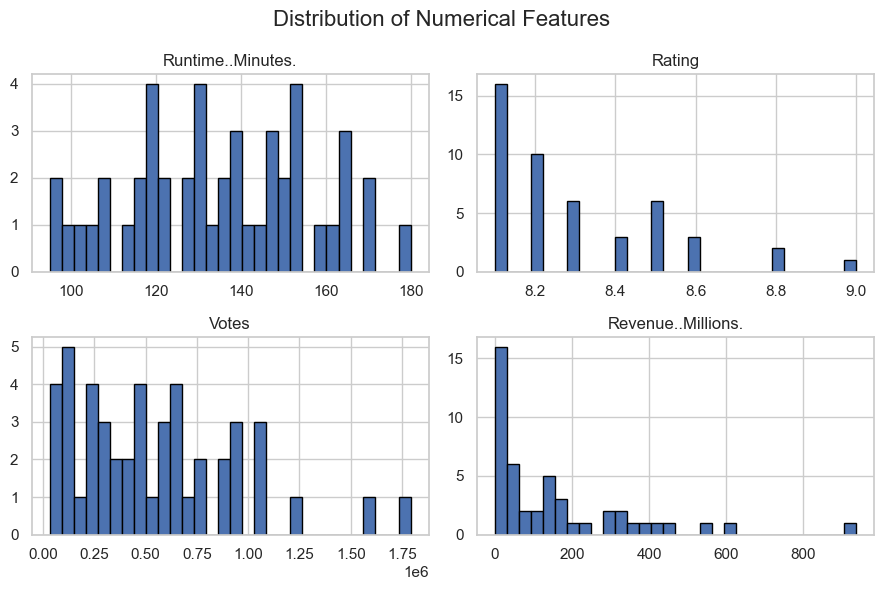

In [130]:
# Histograms for distribution
imdb.hist(bins=30, figsize=(9, 6), edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

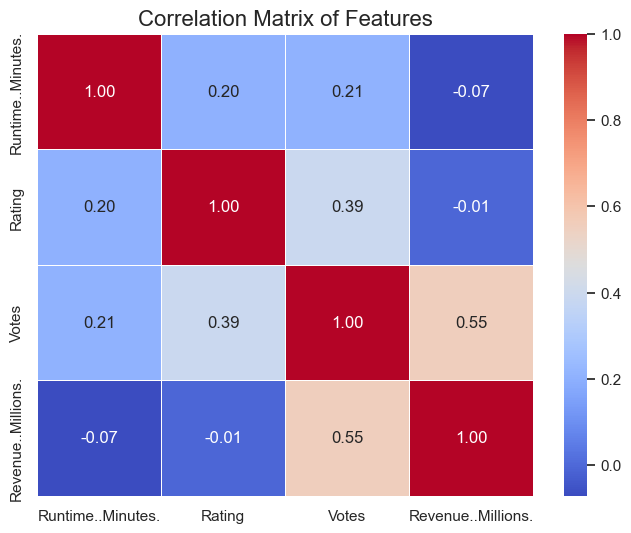

In [131]:
# Correlation matrix for correlation
plt.figure(figsize=(8, 6))
sns.heatmap(imdb.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

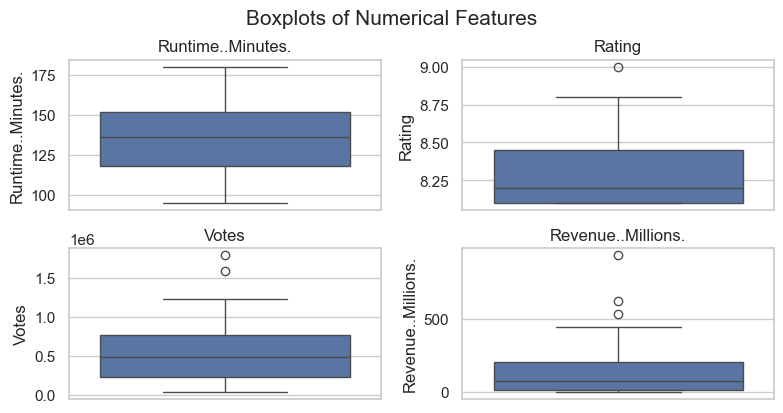

In [132]:
# Boxplots for outliers
plt.figure(figsize=(8, 4))
for i, col in enumerate(imdb.columns, 1):
    plt.subplot(2, int(np.ceil(len(imdb.columns) / 2)), i)
    sns.boxplot(y=imdb[col])
    plt.title(col)
plt.tight_layout()
plt.suptitle("Boxplots of Numerical Features", fontsize=15, y=1.03)
plt.show()

# __2. PCA__

## 2.1. Choosing the numebr of Principal Component

In [133]:
# Apply PCA to reduce to all components
pca_full = PCA()
pcomp_full = pca_full.fit_transform(imdb_scaled)

Explained Variance by Principal Components:
PC1 Variance Captured: 43.19% (Cumulative: 43.19%)
PC2 Variance Captured: 29.62% (Cumulative: 72.81%)
PC3 Variance Captured: 19.64% (Cumulative: 92.45%)
PC4 Variance Captured: 7.55% (Cumulative: 100.00%)


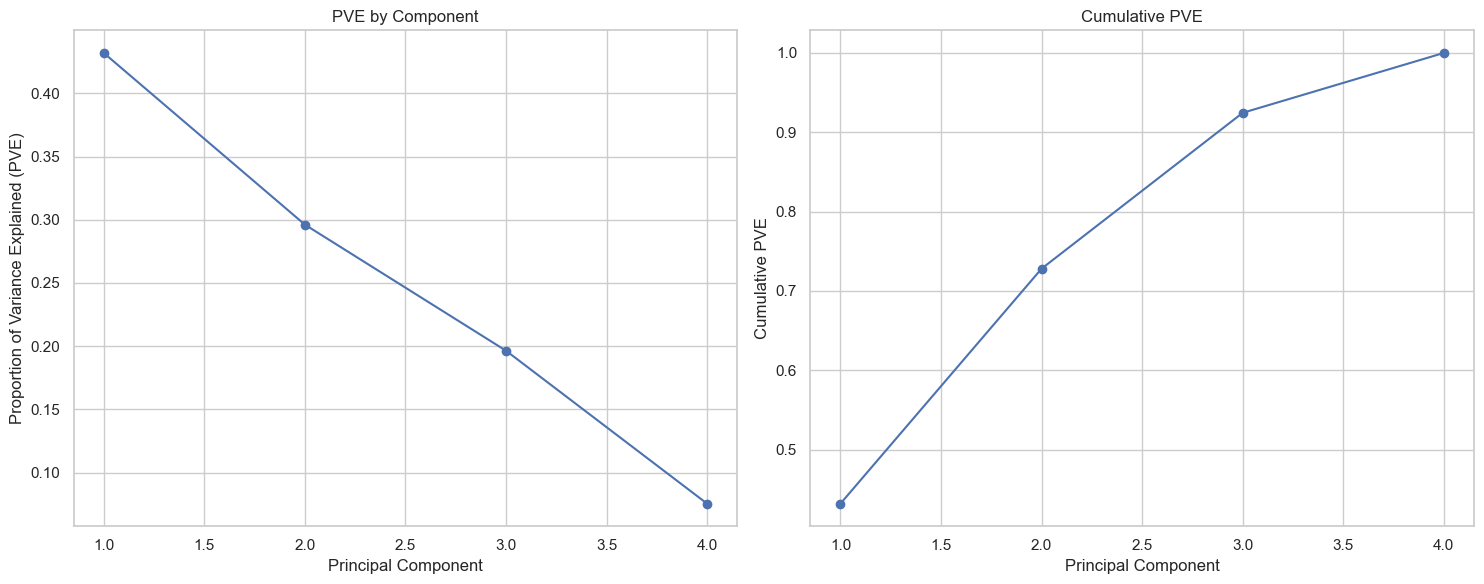

In [134]:
# Display the proportion and cumulative variance explained by each component
print("Explained Variance by Principal Components:")
cumulative_var = 0

for i, ratio in enumerate(pca_full.explained_variance_ratio_, start=1):
    cumulative_var += ratio
    print(f"PC{i} Variance Captured: {ratio:.2%} (Cumulative: {cumulative_var:.2%})")

# PVE and cumulative PVE plots
pca_temp = PCA()
pca_temp.fit(imdb_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PVE Plot
ax = axes[0]
ticks = np.arange(pca_temp.n_components_) + 1
ax.plot(ticks, pca_temp.explained_variance_ratio_, marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained (PVE)')
ax.set_title('PVE by Component')

# Cumulative PVE Plot
ax = axes[1]
ax.plot(ticks, pca_temp.explained_variance_ratio_.cumsum(), marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE')
ax.set_title('Cumulative PVE')

plt.tight_layout()
plt.show()


From the Elbow plot above, we can see that 90% variance captured is reached at PC3 (PC3: 92.45% vs PC2: 72.81%), therefore we are going to use PC1,2,3 for our analysis and models.

In [135]:
# Apply PCA to reduce to 3 components
pca = PCA(n_components=3)
pcomp = pca.fit_transform(imdb_scaled)

# Get component scores
df_pca = pd.DataFrame(data=pcomp, index=imdb.index, columns=['PC1', 'PC2', 'PC3'])
df_pca.head()

,PC1,PC2,PC3
0,4.772326,0.462205,-1.178936
1,3.335473,0.733901,-0.957936
2,0.107999,2.447912,-0.839995
3,1.999436,1.405362,0.235787
4,-1.044810,0.428793,-2.057119


In [136]:
# Get component loadings for each feture
loadings = pca.components_.T
df_pca_load = pd.DataFrame(data=loadings, index=imdb.columns, columns=['PC1', 'PC2', 'PC3'])
df_pca_load

,PC1,PC2,PC3
Runtime..Minutes.,0.274519,0.627404,0.708938
Rating,0.444094,0.472413,-0.674149
Votes,0.693758,-0.115823,0.002863
Revenue..Millions.,0.496105,-0.608091,0.207177


In [137]:
# Combine PC scores with movie titles
df_pca_titles = pd.concat([df['Title'], df_pca], axis=1)
df_pca_titles.head()

,Title,PC1,PC2,PC3
0,The Dark Knight,4.772326,0.462205,-1.178936
1,Inception,3.335473,0.733901,-0.957936
2,Dangal,0.107999,2.447912,-0.839995
3,Interstellar,1.999436,1.405362,0.235787
4,Kimi no na wa,-1.044810,0.428793,-2.057119


## 2.2. Plotting the PCs agaist each other 

#### 2.2.1. 2D plots

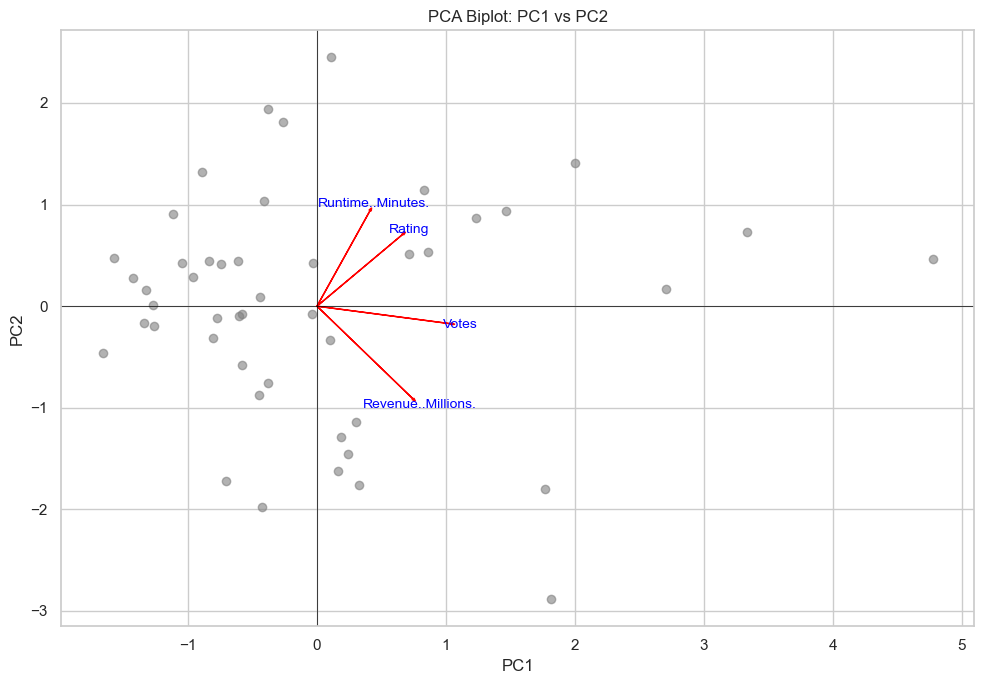

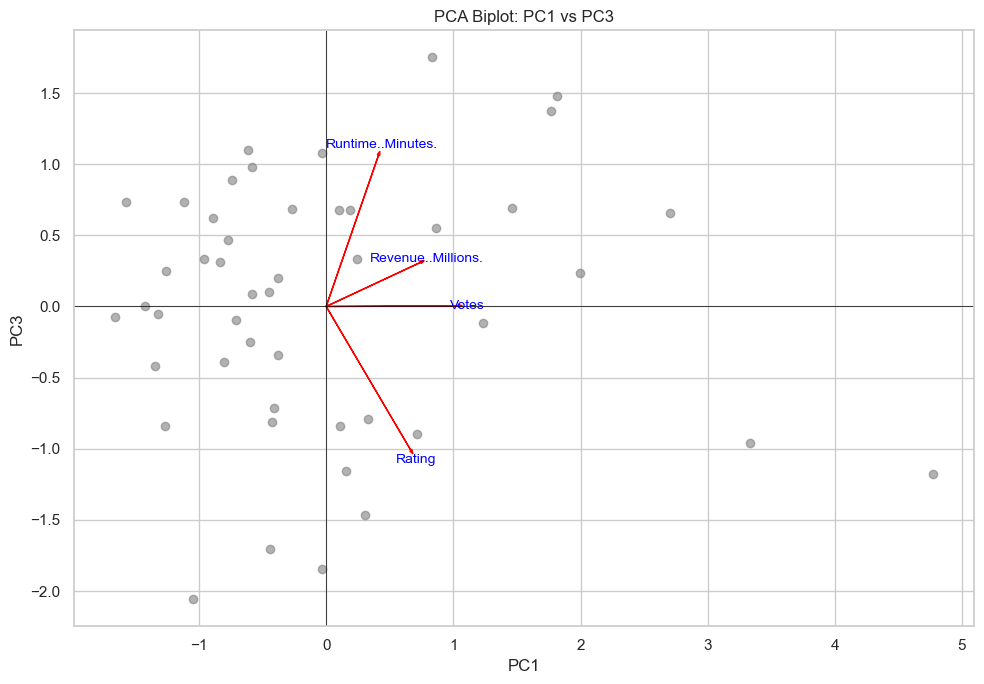

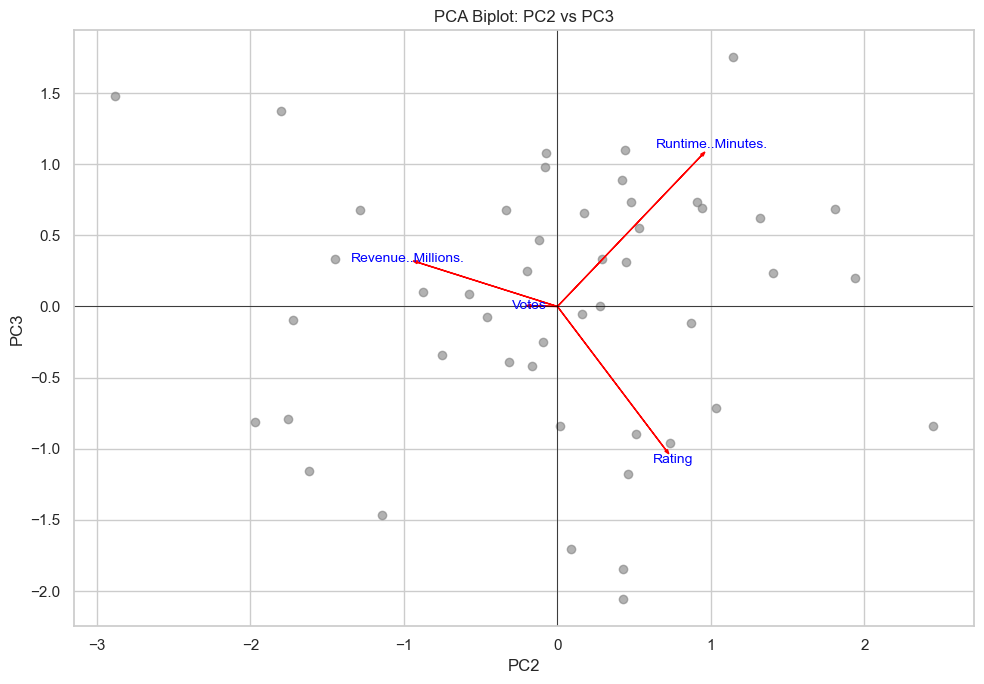

In [138]:
# Get the variables for the model
components = df_pca[['PC1', 'PC2', 'PC3']].values
loadings = pca.components_.T
features = imdb.columns

# Define pairs of principal components to plot
component_pairs = [(0, 1), (0, 2), (1, 2)]

# Loop through each PC pair
for x_id, y_id in component_pairs:
    plt.figure(figsize=(10, 7))
    
    # Plot the data points in 2D PCA space
    plt.scatter(components[:, x_id], components[:, y_id], 
                alpha=0.6, 
                color='gray')
    
    # Overlay arrows for each feature’s loading on 2D PC axis
    for i, feature in enumerate(features):
        # Add the arrows
        plt.arrow(0, 0,
                  loadings[i, x_id] * 1.5,
                  loadings[i, y_id] * 1.5,
                  color='red',
                  head_width=0.02)
        # Add the arrows feature names
        plt.text(loadings[i, x_id] * 1.6,
                 loadings[i, y_id] * 1.6,
                 feature,
                 color='blue',
                 ha='center',
                 va='center',
                 fontsize=10)

    # Plot Lables
    plt.xlabel(f'PC{x_id+1}')
    plt.ylabel(f'PC{y_id+1}')
    plt.title(f'PCA Biplot: PC{x_id+1} vs PC{y_id+1}')
    plt.grid(True)
    plt.axhline(0, color='black', lw=0.5)  # horizontal axis
    plt.axvline(0, color='black', lw=0.5)  # vertical axis
    plt.tight_layout()
    plt.show()


#### 2.2.2. 3D Plot (Stationary)

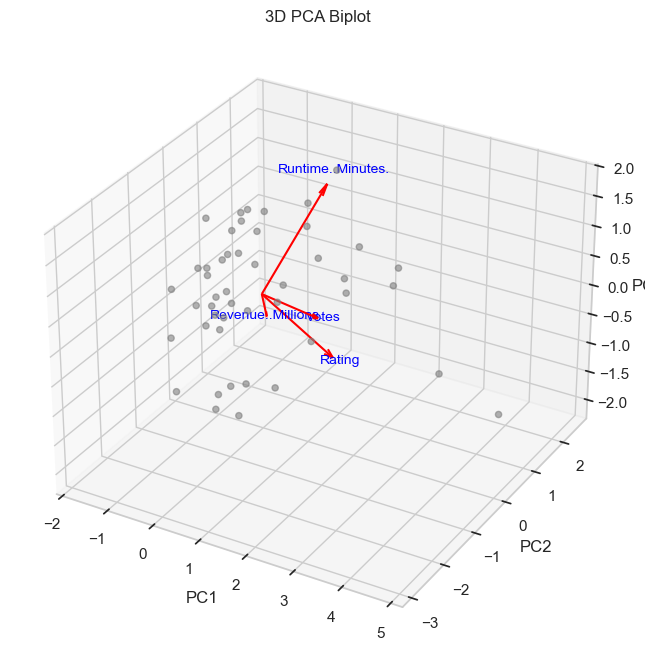

In [139]:
# Create a 3D figure and axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points in 3D PCA space
ax.scatter(components[:, 0], components[:, 1], components[:, 2],
    alpha=0.6,
    color='gray'
)

# Overlay arrows for each feature’s loading on the 3D PC axis
for i, feature in enumerate(features):
    # Add the arrows
    ax.quiver(0, 0, 0,
              loadings[i, 0] * 2,
              loadings[i, 1] * 2,
              loadings[i, 2] * 2,
              color='red',
              arrow_length_ratio=0.1)
    # Add the arrows feature names
    ax.text(loadings[i, 0] * 2.2,
            loadings[i, 1] * 2.2,
            loadings[i, 2] * 2.2,
            feature,
            color='blue',
            fontsize=10,
            ha='center')

# Plot labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Biplot')
plt.show()

#### 2.2.3. 3D Plot (Interactive)

In [140]:
# Base PCA scatter plot (gray points) with movie titles on hover
fig = px.scatter_3d(
    df_pca_titles,
    x='PC1',
    y='PC2',
    z='PC3',
    opacity=0.7,
    color_discrete_sequence=['gray'],
    hover_name='Title',
    title='3D PCA Plot',
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
)

# Define colors for arrows
colors = px.colors.qualitative.D3

# Sort features alphabetically
sorted_features = sorted(zip(features, loadings), key=lambda x: x[0])

# Add arrows for sorted features
for i, (feature, vec) in enumerate(sorted_features):
    fig.add_trace(go.Scatter3d(
        x=[0, vec[0] * 2],
        y=[0, vec[1] * 2],
        z=[0, vec[2] * 2],
        mode='lines+text',
        name=feature,
        text=[None, feature],
        textposition='top center',
        line=dict(color=colors[i % len(colors)], width=4)
    ))

# Layout settings
fig.update_layout(
    width=1000,
    height=800
)
fig.show()


# __3. K-Means Clustering__

## 3.1. Elbow method to find optimal numebr of K-clusters

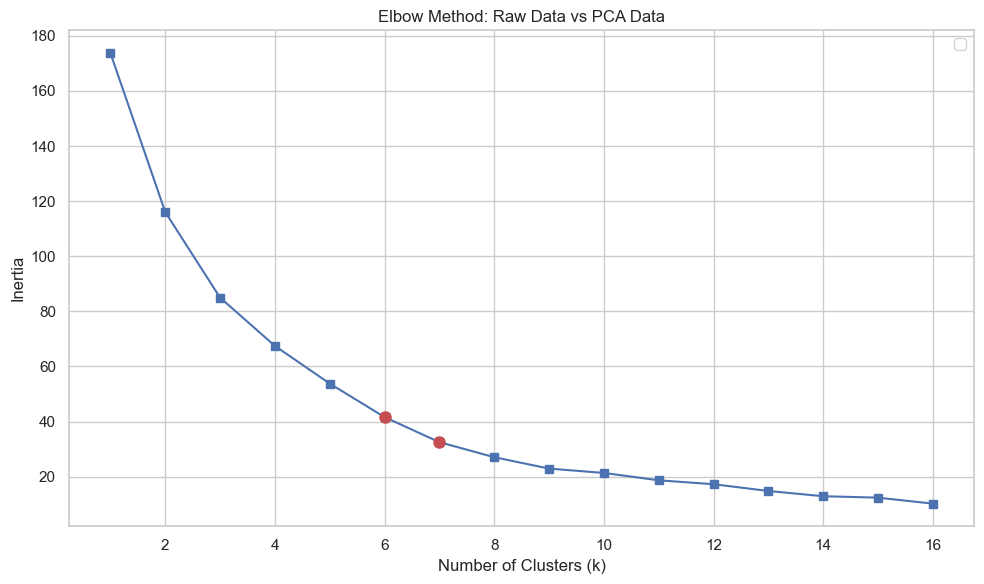

In [ ]:
# Set the range of clusters to check
k_range = range(1, 17)

# Elbow for PCA Data (first 3 PCs)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=rng)
    km.fit(df_pca[['PC1', 'PC2', 'PC3']])
    inertias.append(km.inertia_)

# Initiatea the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_range, inertias, marker='s')

# Highlight possible best number of clusters
ax.plot(6, inertias[5], 'ro', markersize=8)  # point of interest 1
ax.plot(7, inertias[6], 'ro', markersize=8)  # point of interest 2 

# Plot Labels
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method: Raw Data vs PCA Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


From the plot above, we can see that the best number of cluster is around 6 or 7, therefore we will test further to choose best one.

## 3.2. Silhouette Scores for K-Means Clustering

=== K-means Silhouette Scores===
Clusters=5: 0.3128564770257323
Clusters=6: 0.37614963224373915
Clusters=7: 0.3714189652249551
Clusters=8: 0.33564512956841897


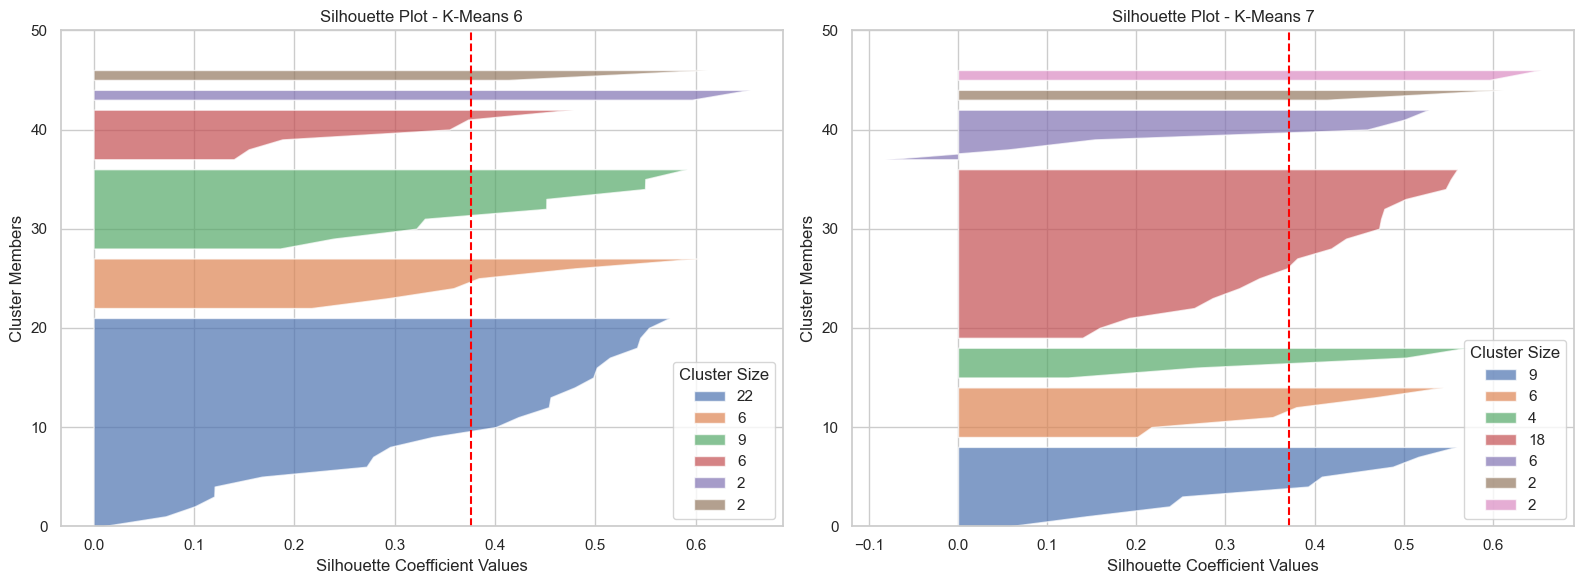

In [142]:
# Lis the numebr of cluster to test
n_clusters_list = [5, 6, 7, 8]  # Add 5 and 8 for safety

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

print("=== K-means Silhouette Scores===")
for n_clusters in n_clusters_list:
    
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=rng)
    labels_kmeans = kmeans.fit_predict(df_pca)
    silhouette_kmeans = silhouette_score(df_pca, labels_kmeans)
    silhouette_vals_kmeans = silhouette_samples(df_pca, labels_kmeans)

    # Print the Silhouette values for comparison
    print(f"Clusters={n_clusters}: {silhouette_kmeans}")

    # Create subplots for side-by-side comparison
    if n_clusters == 6:
        plot_silhouette(axes[0], silhouette_vals_kmeans, np.array(labels_kmeans), "Silhouette Plot - K-Means 6", 6, df_pca)
    elif n_clusters ==7:
        plot_silhouette(axes[1], silhouette_vals_kmeans, np.array(labels_kmeans), "Silhouette Plot - K-Means 7", 7, df_pca)

    
plt.tight_layout()
plt.show()

We can see from these scores that the best number of clusters to choose is 6, with 7 being close second

## 3.3. Plotting the PCs agaist each other with K-Means Clustering

#### 3.3.1. 2D Plots

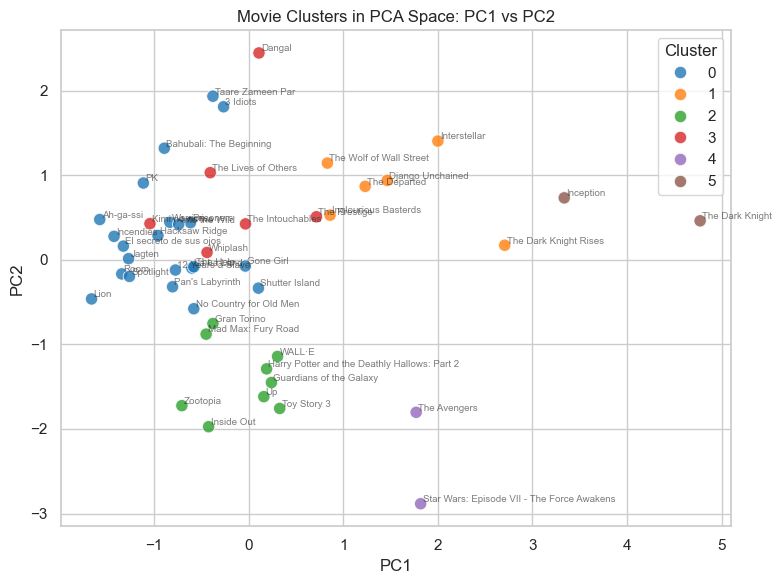

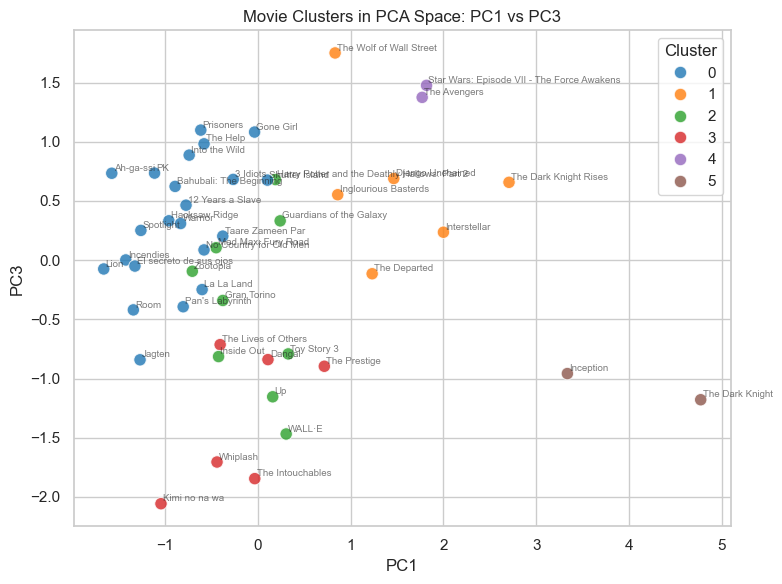

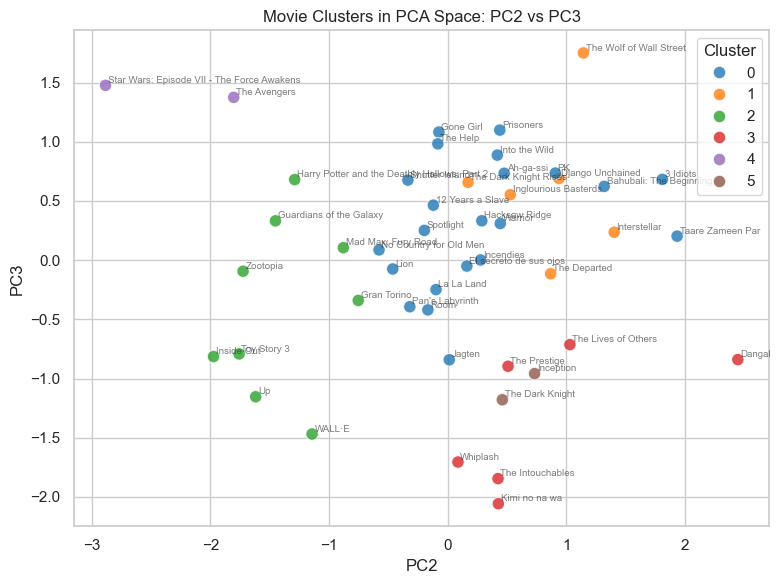

In [143]:
# Create DataFrame from PCA components
df_pca_temp0 = df_pca.copy()

# Fit KMeans on 2D PCA space
kmeans_pca = KMeans(n_clusters=6, n_init=20, random_state=rng)
clusters_pca = kmeans_pca.fit_predict(df_pca_temp0)
# Add cluster labels and movie titles
df_pca_temp0['Cluster'] = clusters_pca
df_pca_temp0['Title'] = df_pca_titles['Title']

# Get list of PCA components
pca_components = ['PC1', 'PC2', 'PC3']
num_components = len(pca_components)

# Loop over all 2D combinations of PCA components
for i in range(num_components):
    for j in range(i + 1, num_components):
        x_comp = pca_components[i]
        y_comp = pca_components[j]

        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x=x_comp, y=y_comp,
            hue='Cluster',
            palette='tab10',
            data=df_pca_temp0,
            s=80,
            alpha=0.8
        )

        # Add movie titles
        for k, row in df_pca_temp0.iterrows():
            plt.text(row[x_comp]+0.02, row[y_comp]+0.02, row['Title'], fontsize=7, alpha=0.6)

        plt.title(f'Movie Clusters in PCA Space: {x_comp} vs {y_comp}')
        plt.xlabel(x_comp)
        plt.ylabel(y_comp)
        plt.legend(title='Cluster', loc='upper right')
        plt.tight_layout()
        plt.show()


#### 3.3.2. 3D Plot (Stationary)

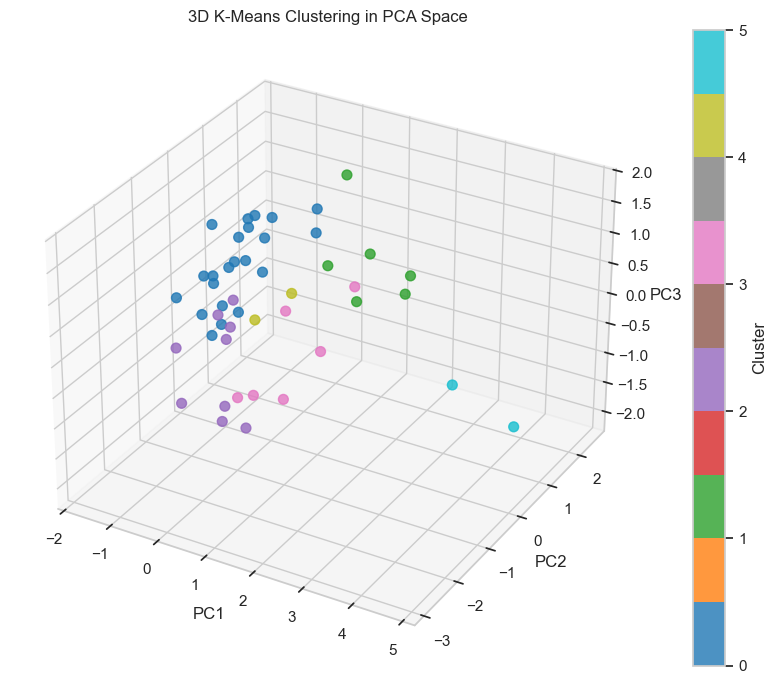

In [144]:
# Create a 3D figure and axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points in 3D PCA space colloring them by their cluster
scatter = ax.scatter(
    df_pca_temp0['PC1'], df_pca_temp0['PC2'], df_pca_temp0['PC3'],
    c=df_pca_temp0['Cluster'], cmap='tab10', s=50, alpha=0.8
)

# Plot Labels
ax.set_title('3D K-Means Clustering in PCA Space')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


#### 3.3.3. 3D Plot (Interactive)

In [145]:
# Create a copy of df_pca_clusters for plotting
df_pca_temp1 = df_pca_temp0.copy()

# Map cluster labels and ensure proper sort order in legend
unique_clusters = sorted(df_pca_temp1['Cluster'].unique())
cluster_map = {old: new for new, old in enumerate(unique_clusters, start=0)}
df_pca_temp1['Cluster'] = df_pca_temp1['Cluster'].map(cluster_map).astype(str)

# Create sorted list for legend order
sorted_cluster_labels = [str(i) for i in sorted(cluster_map.values())]

# Create 3D scatter plot
fig = px.scatter_3d(
    df_pca_temp1, 
    x='PC1', y='PC2', z='PC3',
    color='Cluster',
    title='Interactive 3D K-Means Clustering in PCA Space',
    labels={'Cluster': 'K-Means Cluster'},
    hover_name='Title',
    opacity=0.8,
    category_orders={'Cluster': sorted_cluster_labels}  # Force legend order
)

# Adjust sizes
fig.update_traces(marker=dict(size=10))
fig.update_layout(
    width=1000,
    height=800
)
fig.show()


## 3.4. Pairs plot of the fetures with K-means clusters

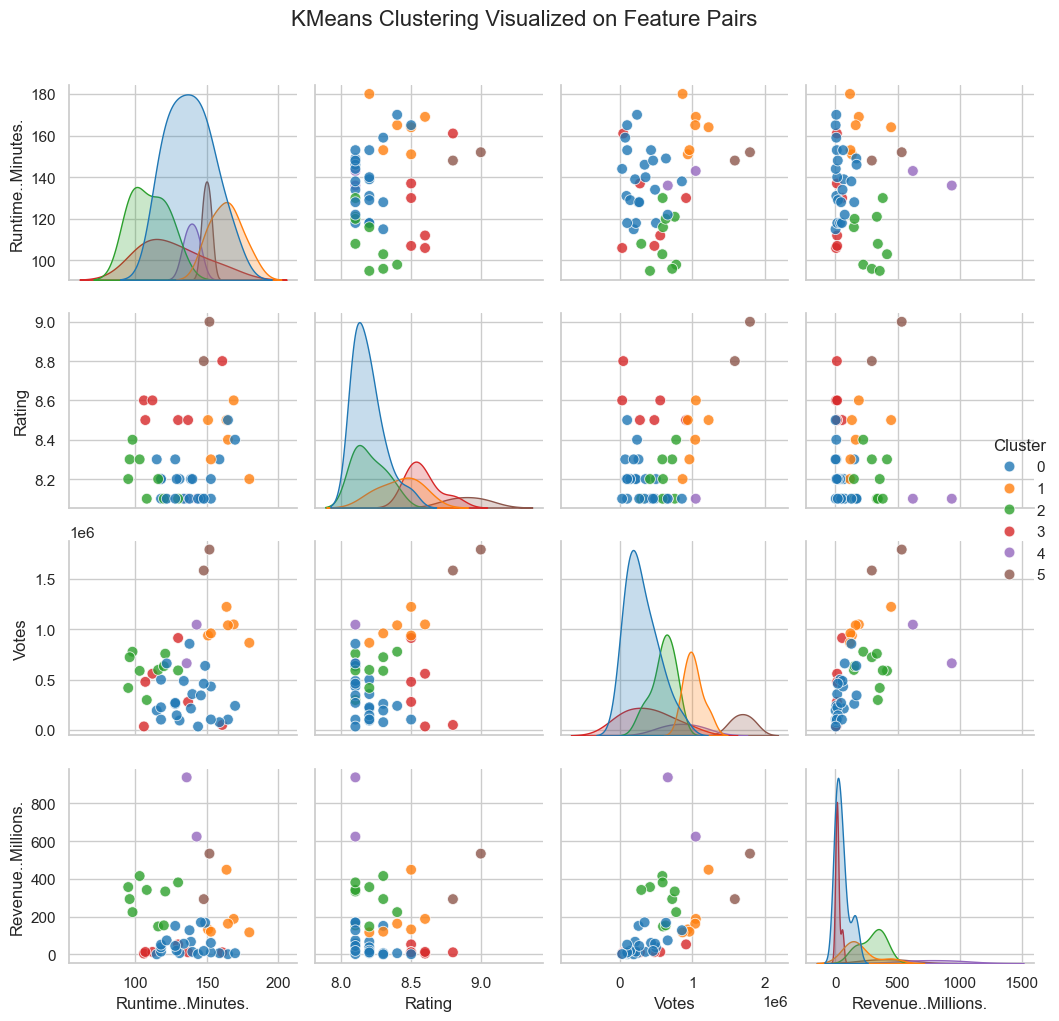

In [146]:
# Convert scaled data to DataFrame
df_pair = pd.DataFrame(imdb, columns=imdb.columns)

# Fit KMeans on PCA-reduced data
kmeans_raw = KMeans(n_clusters=6, n_init=20,random_state=rng)
n_clusters = kmeans_raw.fit_predict(df_pca[['PC1', 'PC2', 'PC3']])

# Add cluster labels and titles
df_pair['Cluster'] = n_clusters
df_pair['Title'] = df_pca_titles['Title']  # assuming index alignment

# Set plot style
sns.set(style="whitegrid")

# Pairplot with diagonal (default is hist)
pairplot = sns.pairplot(
    df_pair,
    vars=imdb.columns,
    hue='Cluster',
    palette='tab10',
    plot_kws={'alpha': 0.8, 's': 60}
)

# Title and layout
plt.suptitle("KMeans Clustering Visualized on Feature Pairs", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


# __4. Hierarchical Clustering__

## 4.1. Perform and Plot the Hierarchical Clustering using Complete/ Average/ Single linkage methods

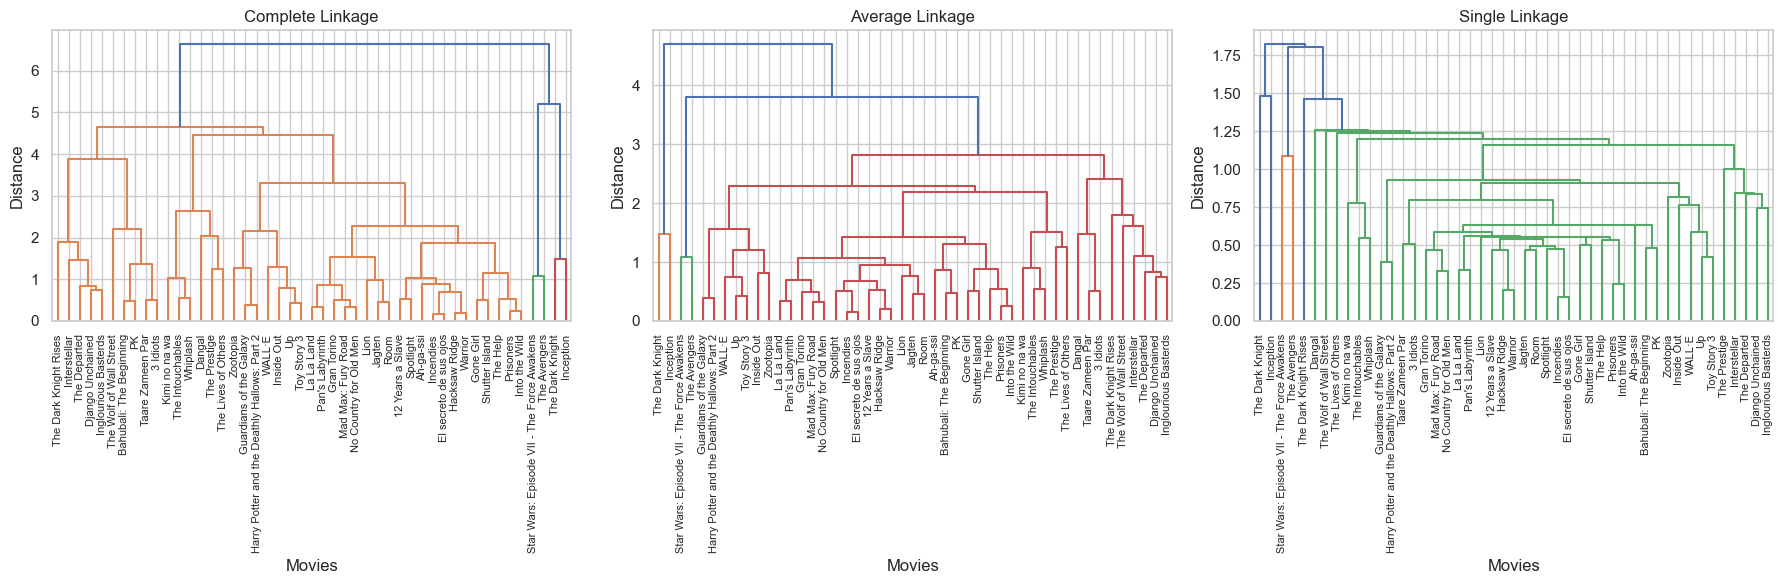

In [147]:
# Define varaibles for the models
titles = df_pca_titles['Title']
linkage_methods = ['complete', 'average', 'single']

# Initialise subplot for each linkage method
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Generate dendograms for each linkage method
for ax, method in zip(axes, linkage_methods):
    dist_matrix = pdist(df_pca, metric='euclidean')
    linkage_matrix = linkage(dist_matrix, method=method)

    dendrogram(linkage_matrix,
                   labels=np.array(titles),
                    ax=ax,
                    leaf_rotation=90,
                    leaf_font_size=8
    )

    # Plot Labels
    ax.set_title(f'{method.capitalize()} Linkage')
    ax.set_xlabel('Movies')
    ax.set_ylabel('Distance')
plt.tight_layout()
plt.show()


From the 3 dendograms above, we can see that the best performing models are using 'Complete' & 'Average' linkage methods, therefore we will focus closer on them.

## 4.2. Silhouette Scores for Hierarchical Clustering

In [148]:
# Defeine cluster list and titles
n_clusters_list = [6,7,8]

# Hierarchical Clustering - Complete Linkage with various clusters
dist_matrix = pdist(df_pca, metric='euclidean')
linkage_complete = linkage(dist_matrix, method='complete')
print("=== COMPLE LINKAGE ===")
for n_clusters in n_clusters_list:
    labels_complete = fcluster(linkage_complete, t=n_clusters, criterion='maxclust')
    silhouette_complete = silhouette_score(df_pca, labels_complete)
    
    # Store silhouette scores
    print(f"Clusters={n_clusters}: {silhouette_complete}")

# Hierarchical Clustering - Average Linkage with various cutoffs
linkage_average = linkage(dist_matrix, method='average')
print("\n=== AVERAGE LINKAGE ===")
for n_clusters in n_clusters_list:
    labels_average = fcluster(linkage_average, t=n_clusters, criterion='maxclust')
    silhouette_average = silhouette_score(df_pca, labels_average)
    
    # Store silhouette scores
    print(f"Clusters={n_clusters}: {silhouette_average}")


=== COMPLE LINKAGE ===
Clusters=6: 0.2889753576423668
Clusters=7: 0.3433114304951801
Clusters=8: 0.33337213125594417

=== AVERAGE LINKAGE ===
Clusters=6: 0.32328521405352323
Clusters=7: 0.37812233673994305
Clusters=8: 0.35345358733646387


## 4.3. Choosing best HClust model

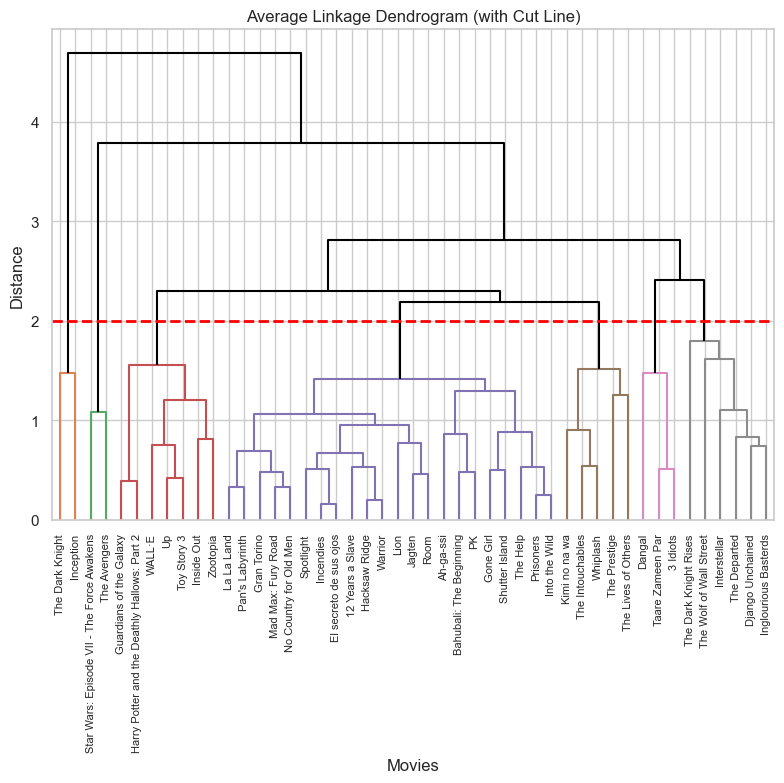

In [149]:
# Best model found
dist_matrix = pdist(df_pca, metric='euclidean')
linkage_matrix = linkage(dist_matrix, method='average')

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the dendogram
dendrogram(
    linkage_matrix,
    labels=np.array(titles),
    ax=ax,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=2.0,  # cut-off line for 7 clusters
    above_threshold_color='black'
)

# Plot labes
ax.set_title('Average Linkage Dendrogram (with Cut Line)')
ax.set_xlabel('Movies')
ax.set_ylabel('Distance')
ax.axhline(2.0, c='red', linewidth=2, linestyle='--')  # Add cut-off line on the plot
plt.tight_layout()
plt.show()

## 4.4. Plotting PCs against each other with Hierarchical Clustering

#### 4.4.1. 3D Plot (Stationary)

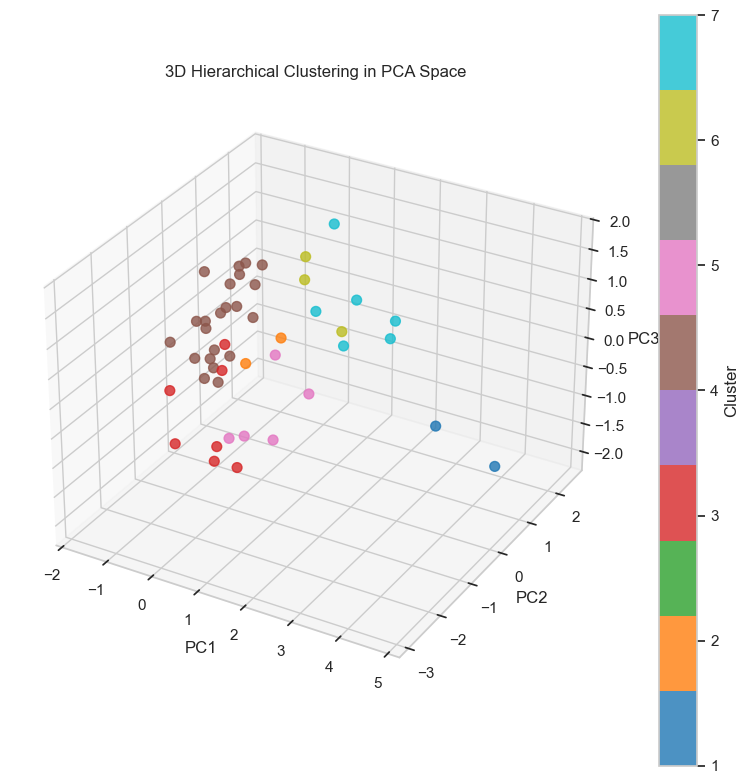

In [150]:
# Make a data set copy
df_pca_temp2 = df_pca.copy()

# Step 1: Compute linkage matrix if not already done
dist_matrix_best = pdist(df_pca_temp2, metric='euclidean')
linkage_matrix_best = linkage(dist_matrix_best, method='average')

# Step 2: Extract flat clusters (e.g., k=7 clusters)
cluster_labels = fcluster(linkage_matrix_best, t=2.0, criterion='distance')

# Step 3: Assign cluster labels back to your df_pca
df_pca_temp2['Hierarchical_Cluster'] = cluster_labels

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_pca_temp2['PC1'], df_pca_temp2['PC2'], df_pca_temp2['PC3'],
    c=df_pca_temp2['Hierarchical_Cluster'], cmap='tab10', s=50, alpha=0.8
)

ax.set_title('3D Hierarchical Clustering in PCA Space')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

#### 4.4.2. 3D Plot (Interactive)

In [ ]:
# Set the best HClust model based on found parameters
hclust_best = fcluster(linkage_matrix_best, t=7.0, criterion='maxclust')

# Assign clusters and prepare labels
df_pca_titles_temp2 = df_pca_titles.copy()
df_pca_titles_temp2['Hierarchical_Cluster'] = pd.Series(hclust_best).astype(str)

# Create ordered cluster labels for legend
unique_clusters = sorted(np.unique(hclust_best))
sorted_cluster_labels = [str(i) for i in unique_clusters]

# Plot the 3D PC plot with hirarchical clustering
fig = px.scatter_3d(
    df_pca_titles_temp2,
    x='PC1', y='PC2', z='PC3',
    color='Hierarchical_Cluster',
    hover_name='Title',
    title='3D Hierarchical Clustering Scatter Plot (Cut at Distance = 2.0, Number of Clusters = 7)',
    labels={'Hierarchical_Cluster': 'Cluster'},
    category_orders={'Hierarchical_Cluster': sorted_cluster_labels},
    opacity=0.8
)

fig.update_traces(marker=dict(size=10))
fig.update_layout(width=1000, height=800)
fig.show()

# __5. Compare K-Means & Hierarchical Clustering Methods__

## 5.1. Hierarchical vs KMeans Comparison Table

In [152]:
# Hierarchical clustering
linkage_comp = linkage(imdb_scaled, method='average')
comp_cut = cut_tree(linkage_comp, n_clusters=7).reshape(-1)

# KMeans clustering
kmeans_comp = KMeans(n_clusters=6, random_state=rng, n_init=20)
comp_labels = kmeans_comp.fit_predict(imdb_scaled)

# Crosstab comparison
pd.crosstab(pd.Series(comp_cut, name='HClust'),
            pd.Series(comp_labels, name='KMeans'))

KMeans,0,1,2,3,4,5
HClust,,,,,,
0,0,0,0,0,2,0
1,0,0,0,0,0,1
2,6,0,0,0,0,1
3,0,0,0,0,0,4
4,0,20,0,2,0,2
5,0,0,0,7,0,0
6,0,0,2,0,0,0


Since we see that there is varaition in the two models, we need to compare them further to select one with more reasonable clustering

## 5.2. Silhouette Scores Comparison

In [1]:
# Compute pairwise distances for hierarchical clustering
dist_matrix = pdist(df_pca, metric='euclidean')

# Hierarchical Clustering - Average Linkage with a cutoff at 2.1
linkage_average = linkage(dist_matrix, method='average')
labels_average = fcluster(linkage_average, t=7, criterion='maxclust')

# Compute silhouette score for average linkage clustering
silhouette_average = silhouette_score(df_pca, labels_average)
silhouette_vals_average = silhouette_samples(df_pca, labels_average)

# K-Means Clustering with 6 clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=rng)
labels_kmeans = kmeans.fit_predict(df_pca)

# Compute silhouette score for K-Means clustering
silhouette_kmeans = silhouette_score(df_pca, labels_kmeans)
silhouette_vals_kmeans = silhouette_samples(df_pca, labels_kmeans)

# Print Silhouette Scores
print(f"======= Silhouette Scores ======="
      f"\nK-Means      (6 clusters): {silhouette_kmeans:.5f}",
      f"\nHierarchical (7 clusters): {silhouette_average:.5f}",
      f"\n\nDifference               : {round((silhouette_average-silhouette_kmeans), 5)}")

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Plot silhouette scores for each clustering method in the respective subplot
plot_silhouette_hclust(axes[0], silhouette_vals_average, labels_average, "Silhouette Plot - Best Hirachical Model", 7, df_pca)
plot_silhouette(axes[1], silhouette_vals_kmeans, labels_kmeans, "Silhouette Plot - Best K-Means Model", 6, df_pca)

# Display the plots
plt.tight_layout()
plt.show()

NameError: name 'pdist' is not defined